## Three-dimensional hyperbolic systems

### Navier Stokes equation in 3d

First we are going to study the three-dimensional Navier-Stokes equation 
\begin{align}
    \frac{\partial}{\partial t} n &= - \nabla\cdot\left( nu\vec { b}\right) \\
    \frac{\partial}{\partial t} u &= - \nabla_\parallel\left(\frac{u^2}{2}\right) - \frac{\tau}{\mu} \frac{\nabla_\parallel n}{n} + \nu_u \frac{\Delta_\parallel u}{n}
\end{align}
with
\begin{align}
\Delta_\parallel u &= \nabla\cdot ( \vec {b}\vec {b}\cdot\nabla u)
\end{align} 
$\vec {b} = \vec {b}(\vec x)$ is the prescribed magnetic field unit vector,
and $\nu_u$ is the viscosity coefficient parallel to this field.

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim

In [3]:
def create_inputfile() :
    inputfile = fp.load_calibration_default()
    inputfile["magnetic_field"]["params"] = mag.select("guenther.json")

    scaleR = [1.0,1.0]
    scaleZ = [1.0,1.0]
    inputfile["grid"] = {"Nx" : 32, "Ny" : 32, "Nz": 20, "n": 3,
                         "scaleR" : scaleR, "scaleZ" : scaleZ}
    inputfile["boundary"]["wall"] = {"type" : "none" }
    inputfile["boundary"]["sheath"] = {"type" : "none" }

    inputfile["init"] ={
        "type" : "fields",
        "density": {    
            "type" : "ne",
            "ntilde": {
                "type" : "circle", # secret init condition in Feltor
                "amplitude" : 1.0,
                "posX" : 0.5,
                "posY" : 0.0,
                "sigma" : 0.2,
                "rk4eps" :1e-6,
                "revolutions" : 1,
                "parallel" : "double-step", # secret non-symmetric init condition
                "sigma_z" : 0.5
            },
            "profile" : {
                "type" : "const",
                "background" : 0.2
            },
            "damping": {
                "type" : "none"
            }
        },
        "potential" : {"type" : "zero_pol"},
        "velocity"  : {"type" : "zero"}, 
        "aparallel" : {"type" : "zero"}
    }
    inputfile["regularization"] = {
        "direction" : "centered",
        "nu_perp_n" : 0,
        "nu_perp_u" : 0,
        "order" : 2
    }
    inputfile["source"] = {
        "minne" : 0.,
        "type" : "zero"
    }
    inputfile["timestepper"] = {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-7,
        "atol" : 1e-10,
        "output-mode" : "equidistant",
        "Tend" : 10
    }
    inputfile["FCI"]["periodify"] = False
    inputfile["advection"]= {
        "type"  : "centered",
        "slope-limiter" : "none"}
    inputfile["physical"]["tau"] = 1.0
    inputfile["physical"]["viscosity"] = "value"
    inputfile["physical"]["nu_parallel"] = [0,1]
    inputfile["output"] = {
        "type" : "netcdf",
        "inner_loop" : 2,
        "itstp" : 20,
        "maxout" : 5,
        "compression" : [1,1]
    }
    return inputfile

inputfile = create_inputfile()
print("grid", json.dumps( inputfile["grid"], indent=4,sort_keys=True))
print("init", json.dumps( inputfile["init"], indent=4,sort_keys=True))
print("advection", json.dumps( inputfile["advection"], indent=4,sort_keys=True))

grid {
    "Nx": 32,
    "Ny": 32,
    "Nz": 20,
    "n": 3,
    "scaleR": [
        1.0,
        1.0
    ],
    "scaleZ": [
        1.0,
        1.0
    ]
}
init {
    "aparallel": {
        "type": "zero"
    },
    "density": {
        "damping": {
            "type": "none"
        },
        "ntilde": {
            "amplitude": 1.0,
            "parallel": "double-step",
            "posX": 0.5,
            "posY": 0.0,
            "revolutions": 1,
            "rk4eps": 1e-06,
            "sigma": 0.2,
            "sigma_z": 0.5,
            "type": "circle"
        },
        "profile": {
            "background": 0.2,
            "type": "const"
        },
        "type": "ne"
    },
    "potential": {
        "type": "zero_pol"
    },
    "type": "fields",
    "velocity": {
        "type": "zero"
    }
}
advection {
    "slope-limiter": "none",
    "type": "centered"
}


In [2]:
rep = simplesim.Manager( executable="./feltor.sh", directory="ThreeDimensional/calibrate", filetype="nc")

In [4]:
def plot( simulationfile):
    simfile = rep.create( simulationfile)
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    
    print( f"{simfile}")
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}")
    frows = 1
    fcols = 1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc = np.kron( np.ones(np.shape(y)),x).reshape( (np.size(y), np.size(x)))
    yc = np.kron( y, np.ones(np.shape(x))).reshape( (np.size(y), np.size(x)))
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*12,frows*9),dpi= 80, facecolor='w', edgecolor='k')

    im = ax.pcolormesh(xc, yc, ncin["lparallelinv_ta2d"][0,:,:],
                       vmin=0, vmax=0.03,
                       cmap="gist_heat_r", shading="gouraud") 
    fig.colorbar(im, ax=ax)
    ax.axis("scaled")
    ax.set_xlabel( "R [mm]")
    ax.set_ylabel( "Z [mm]")
    plt.show()

### Fieldaligned derivatives
In this first experiment we initialize a disc in the plane at $\varphi=0$. 
Then, we transform the disc along the fieldlines half around the torus in both directions.
We can then apply the FCI derivative. Analytically $\nabla_\parallel f=0$ except at both ends of the disc
where the derivatives diverge.

In the following we see that this is not true numerically.

ThreeDimensional/calibrate/d1cccb6d3e2f8069a9a594d2ee094c7edb2620ef.nc
n: 3, Nx: 32, Nz: 20, mx: 1, method: dg


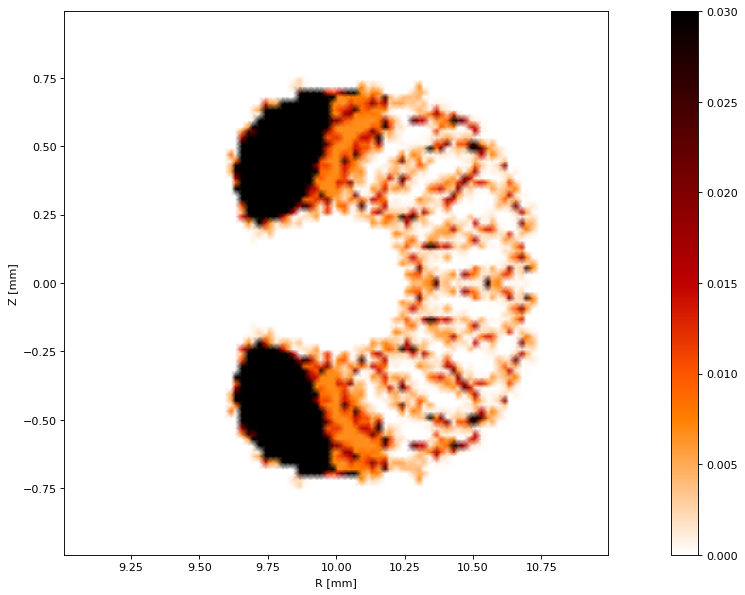

ThreeDimensional/calibrate/051fc9fdf756ec106f4aea0fe9a3be7fb45d6d15.nc
n: 3, Nx: 32, Nz: 20, mx: 10, method: dg


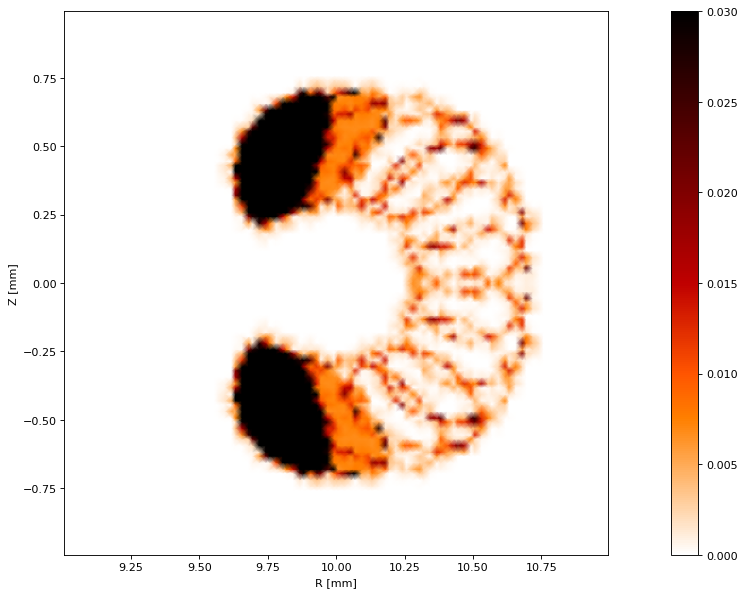

In [6]:
for method in ["dg"]:
    for mx in [1,10]:
        simulationfile = create_inputfile()
        simulationfile["flags"] = []
        simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
        simulationfile["output"]["maxout"] = 0
        simulationfile["advection"]["type"] = "centered"
        simulationfile["physical"]["nu_parallel"] = [0,1]

        simulationfile["FCI"]["refine"] = [mx,mx]
        simulationfile["FCI"]["interpolation-method"] = method
        simulationfile["grid"]["n"] = 3
        simulationfile["grid"]["Nx"] = 32
        simulationfile["grid"]["Ny"] = 32
        simulationfile["grid"]["Nz"] = 20
        plot(simulationfile)

We now change the interpolation method to a bi-linear one, hoping that
less oscillations appear.

ThreeDimensional/calibrate/95aeb52f8da5fc225b7bd78c3035532a1df36a1a.nc
n: 3, Nx: 32, Nz: 20, mx: 1, method: linear


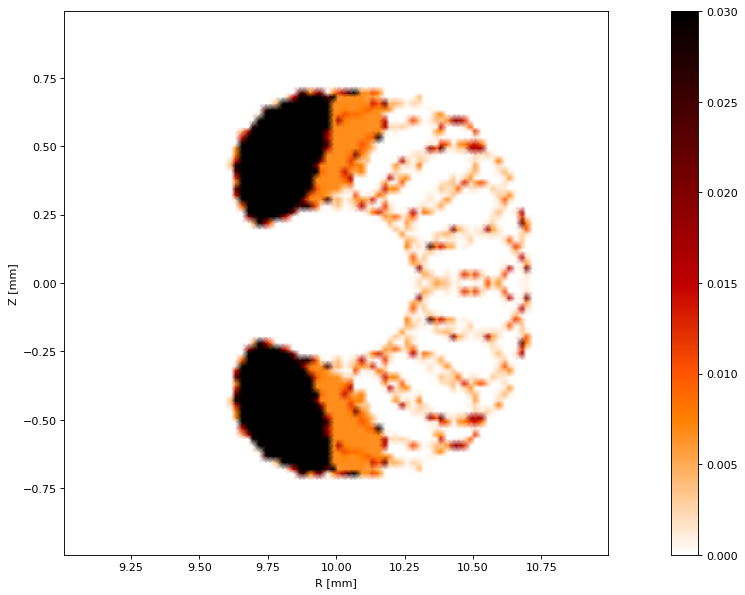

ThreeDimensional/calibrate/bada82a675c935bbd0672fe8f1fcd7d33ce9653c.nc
n: 3, Nx: 32, Nz: 20, mx: 10, method: linear


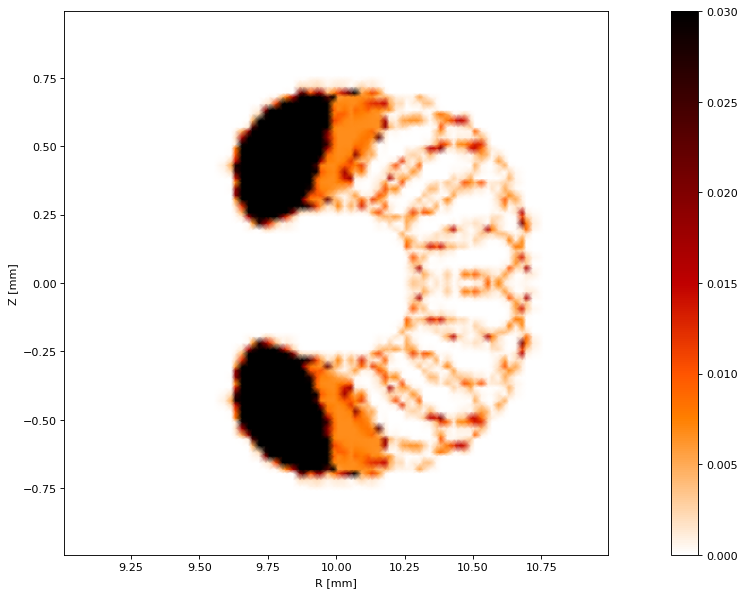

In [7]:
for method in ["linear"]:
    for mx in [1,10]:
        simulationfile = create_inputfile()
        simulationfile["flags"] = []
        simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
        simulationfile["output"]["maxout"] = 0
        simulationfile["advection"]["type"] = "centered"
        simulationfile["physical"]["nu_parallel"] = [0,1]

        simulationfile["FCI"]["refine"] = [mx,mx]
        simulationfile["FCI"]["interpolation-method"] = method
        simulationfile["grid"]["n"] = 3
        simulationfile["grid"]["Nx"] = 32
        simulationfile["grid"]["Ny"] = 32
        simulationfile["grid"]["Nz"] = 20
        plot(simulationfile)

We can also try to increase the perpendicular resolution. We see that the oscillations become smaller in size but do not vanish (likely because the step is sharp).

ThreeDimensional/calibrate/3fcdc048c3a6d9ff7c8c67868d415770d31addb5.nc
n: 3, Nx: 60, Nz: 20, mx: 5, method: linear


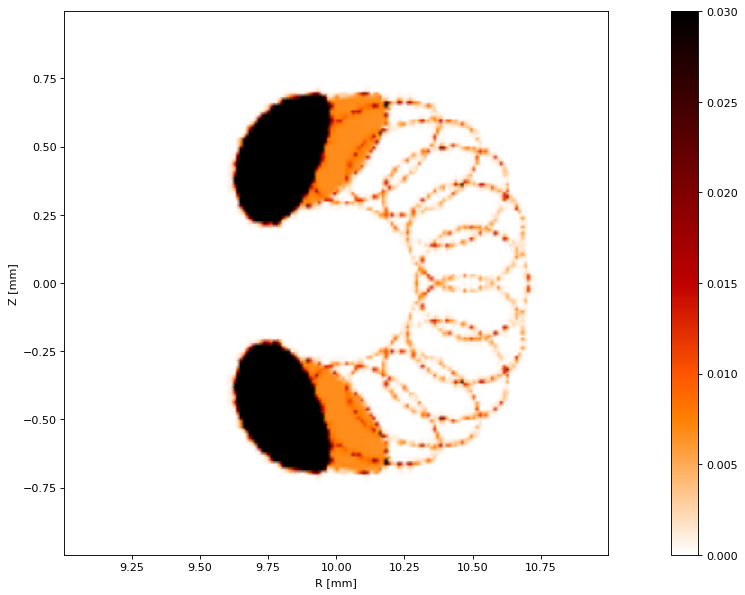

In [8]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
simulationfile["output"]["maxout"] = 0
simulationfile["advection"]["type"] = "centered"
simulationfile["physical"]["nu_parallel"] = [0,1]

simulationfile["FCI"]["refine"] = [5,5]
simulationfile["FCI"]["interpolation-method"] = "linear"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 60
simulationfile["grid"]["Ny"] = 60
simulationfile["grid"]["Nz"] = 20
plot(simulationfile)

We can also try to vary the number of polynomials in the dg interpolation method:
Clearly the higher the polynomial number the more oscillations appear.

Running simulation ...7ac229ca4.nc
ThreeDimensional/calibrate/435cf49b6795b03884010482c69b3f17ac229ca4.nc
n: 2, Nx: 50, Nz: 20, mx: 5, method: dg


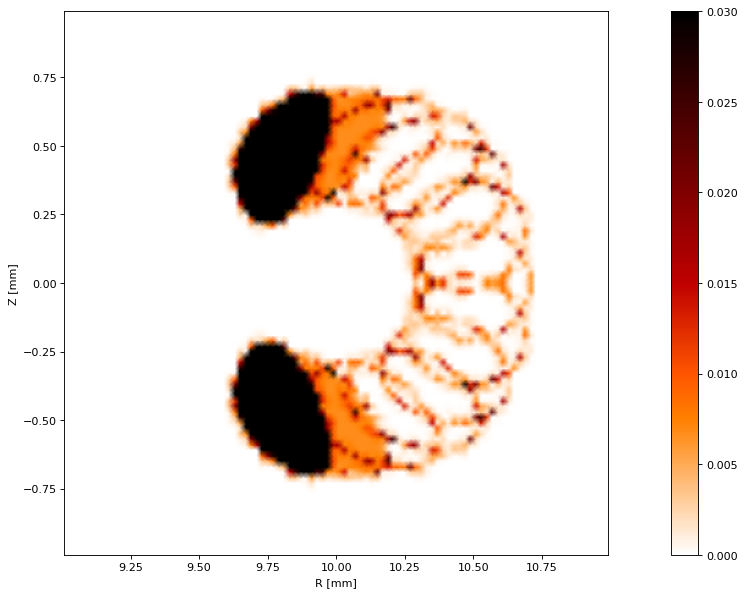

Running simulation ...58e3eb21d.nc
ThreeDimensional/calibrate/b48972247b34cb9dc73f34ffa8909f058e3eb21d.nc
n: 5, Nx: 20, Nz: 20, mx: 5, method: dg


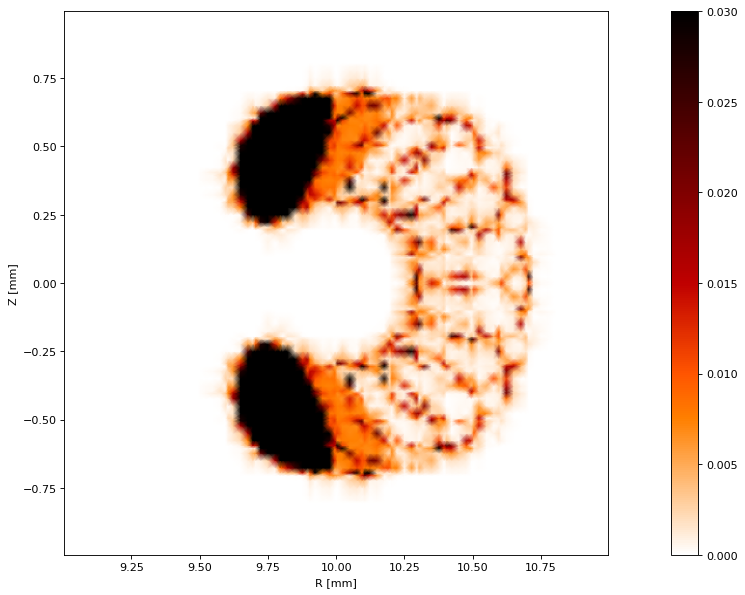

In [9]:
for n in [2,5] :
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
    simulationfile["output"]["maxout"] = 0
    simulationfile["advection"]["type"] = "centered"
    simulationfile["physical"]["nu_parallel"] = [0,1]

    simulationfile["FCI"]["refine"] = [5,5]
    simulationfile["FCI"]["interpolation-method"] = "dg"
    simulationfile["grid"]["n"] = n
    simulationfile["grid"]["Nx"] = 20
    simulationfile["grid"]["Ny"] = 20
    if n == 2 :
        simulationfile["grid"]["Nx"] = 50
        simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = 20
    plot(simulationfile)

In [10]:
# Define a plotting routine for the conservation equations
def plot_conservation( simfile, diagfile, plotfile, index):
    plt.rcParams.update({'font.size': 14})
    frows = 4
    fcols = 2
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1.25*6,frows*1.25*4),dpi= 80, facecolor='w', edgecolor='k')
    
    dset = Dataset( diagfile, 'r', format="NETCDF4")
    simset = Dataset( simfile, 'r', format="NETCDF4")
    plotset = Dataset( plotfile, 'r', format="NETCDF4")
    pp = json.loads(dset.inputfile)
    x = dset["x"][:]
    y = dset["y"][:]
    xc = np.kron( np.ones(np.shape(y)),x).reshape( (np.size(y), np.size(x)))
    yc = np.kron( y, np.ones(np.shape(x))).reshape( (np.size(y), np.size(x)))
    # 3d plot section
    xf = plotset["xf"][:]
    yf = plotset["yf"][:]
    zf = plotset["zf"][:]
    xfc2d = np.kron( np.ones(np.shape(zf)),xf).reshape( (np.size(zf), np.size(xf)))
    zfc2d = np.kron( zf, np.ones(np.shape(xf))).reshape( (np.size(zf), np.size(xf)))
    sectionY = pp["grid"]["Ny"]*pp["grid"]["n"]/2
    middleX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.5)/2 
    rightX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.71)/2
    ##
    time = dset['time'][:]
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    rho = dset['rho'][:]
    rho_t = dset['rho_t'][:]
    area = dset['psi_area'][:]
    volume = dset['psi_vol'][:]
    print( f"file : {simfile}")
    print( f"scheme = {pp['advection']['type']}", end=" ")
    print( f"limiter = {pp['advection']['slope-limiter']}", end=" ")
    print(f"time = {time[index]:5.2f}")
    gg = pp["grid"]
    fci = pp["FCI"]
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}")
    
    
    # Mass conservation
    
    mass =dset['ions_fsa'][:,:]
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = dset['sni_tt_fsa'][:,:]/deltat[:,None]
    deltamass-=source
    
    divjvne=dset['divjnipar_tt_fsa'][:,:]/deltat[:,None]
    rhs = 0 # divjvne
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:,:], axis=0)
    average_std =  np.std( diff[1:,:], axis=0)
    rr = 0
    cc = 1
    ax[rr][cc].plot( rho_t[0:167], average_diff[0:167], ls = '-', color='r', lw = 4)
    ax[rr][cc].fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='r', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    ax[rr][cc].set_xlabel(r"$\rho_t$")
#     plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
    rr = 0
    cc = 0
    lower = 0.1
    upper = 0.5
    vo = simset['ions_2d'][index,:,:]
    im = ax[rr][cc].pcolormesh(xc,yc,vo, vmin=lower, vmax=upper, shading='gouraud', cmap='jet' )
    ax[rr][cc].axis('scaled')
    
#     vo = plotset['ionsFF'][index,:,sectionY,:]
#     im = ax[rr][cc].pcolormesh(xfc2d,zfc2d,vo,vmin=lower,vmax=upper, shading='gouraud', cmap='gist_ncar_r' )

    ax[rr][cc].set_title("Mass")
    fig.colorbar( im , ax=ax[rr][cc])
#     ax[rr][cc].plot( rho_t[0:167], mass[index, 0:167], ls = '-', color='r', lw = 4, label='mass')
#     ax[rr][cc].set_xlabel(r"$\rho_t$")
#     ax[rr][cc].legend()
    
    # Momentum conservation
    momentum = dset['niui_fsa'][:,:] 
    momentumtt=np.append(np.zeros((1,len(rho))),momentum, axis=0)
    deltamomentum = np.diff(momentumtt,axis=0)/deltat[:,None]
    source = dset.variables['sei_tt_fsa'][:,:]/deltat[:,None]
    deltamomentum-=source
    
    divjvne=dset['divjpari_tt_fsa'][:,:]/deltat[:,None]
    force = dset['sparmirrori_tt_fsa'][:,:]/deltat[:,None]
    diff_para = dset["lparpar_tt_fsa"][:,:]/deltat[:,None]
    rhs =  - force - diff_para # + divjne
    diff = (deltamomentum + rhs)/2
   
    average_diff = np.mean( diff[1:,:], axis=0)
    average_std =  np.std( diff[1:,:], axis=0)
    rr = 1
    cc = 1
    ax[rr][cc].plot( rho_t[0:167], average_diff[0:167], ls = '-', color='r', lw = 4)
    ax[rr][cc].fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='r', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    ax[rr][cc].set_xlabel(r"$\rho_t$")
#     plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
    rr = 1
    cc = 0    
    lower = -0.2
    upper = 0.2
    vo = simset['niui_2d'][index,:,:]
    im = ax[rr][cc].pcolormesh(xc,yc,vo, vmin=lower, vmax=upper, shading='gouraud', cmap='seismic' )
    ax[rr][cc].axis('scaled')
#     vo = plotset['UiFF'][index,:,sectionY,:]
#     im = ax[rr][cc].pcolormesh(xfc2d,zfc2d,vo,vmin=lower,vmax=upper, shading='gouraud', cmap='seismic' )

    ax[rr][cc].set_title("Momentum")
    fig.colorbar( im , ax=ax[rr][cc])
#     ax[rr][cc].plot( rho_t[0:167], momentum[index, 0:167], ls = '-', color='r', lw = 4, label='momentum')
#     ax[rr][cc].set_xlabel(r"$\rho_t$")
#     ax[rr][cc].legend()
        
    # Energy conservation
    energy = dset['nilnni_fsa'][:,:] + dset['niui2_fsa'][:,:]
    energytt=np.append(np.zeros((1,len(rho))),energy, axis=0)
    deltaenergy = np.diff(energytt,axis=0)/deltat[:,None]
    source = dset.variables['sei_tt_fsa'][:,:]/deltat[:,None]
    deltaenergy-=source
    
#     divjv=dset['divjeipar_tt_fsa'][:,:]/deltat[:,None]
    diff_para = dset["leiparallel_tt_fsa"][:,:]/deltat[:,None]
    rhs = - diff_para# +divjv 
    diff = (deltaenergy + rhs)/2
   
    average_diff = np.mean( diff[1:,:], axis=0)
    average_std =  np.std( diff[1:,:], axis=0)
    rr = 2
    cc = 1
    ax[rr][cc].plot( rho_t[0:167], average_diff[0:167], ls = '-', color='r', lw = 4)
    ax[rr][cc].fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='r', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    ax[rr][cc].set_xlabel(r"$\rho_t$")
#     plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
    rr = 2
    cc = 0
    lower = -0.35
    upper = -0.15
    vo = simset['nilnni_2d'][index,:,:] + simset["niui2_2d"][index,:,:]
    im = ax[rr][cc].pcolormesh(xc,yc,vo, vmin=lower, vmax=upper, shading='gouraud', cmap='plasma' )
    ax[rr][cc].axis('scaled')
    ax[rr][cc].set_title("Energy")
    fig.colorbar(im, ax=ax[rr][cc])
#     ax[rr][cc].plot( rho_t[0:167], energy[index, 0:167], ls = '-', color='r', lw = 4, label='energy')
#     ax[rr][cc].set_xlabel(r"$\rho_t$") 
#     ax[rr][cc].legend()
    
    rr = 3
    cc = 0
    ax[rr][cc].plot( zf, plotset["ionsFF"][index, :, sectionY, middleX], ls = '-', color='r', lw = 4)
    rr = 3
    cc = 1
    ax[rr][cc].plot( zf, plotset["ionsFF"][index, :, sectionY, rightX], ls = '-', color='r', lw = 4)
    dset.close()
    simset.close()
    plotset.close()
    
    plt.show()
    # plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    # plt.xlim(60,130)
    # plt.ylim(-0.05,0.05)
    # plt.ylim(0,30000)


In [11]:
simulator = simplesim.Manager( executable="./feltor.sh", directory="ThreeDimensional/data", filetype="nc")
diagnoser = simplesim.Manager( executable="./feltordiag.sh", directory="ThreeDimensional/diag", filetype="nc")
interpolator = simplesim.Manager( executable ="./feltorplot.sh",
                                  directory="ThreeDimensional/plot", filetype = "nc")
# help (simplesim)

### Navier-Stokes equation in 3d
First, let us try to simulate the centered scheme and the velocity-staggered scheme with the linear interpolation scheme. We see that the centered scheme, as expected, produces oscillations (that without parallel diffusion become unstable immediately).

file : ThreeDimensional/data/e176dbd837c3867b37bcfd08998718b721b6b05b.nc
scheme = centered limiter = none time = 10.00
n: 3, Nx: 20, Nz: 20, mx: 5, method: linear


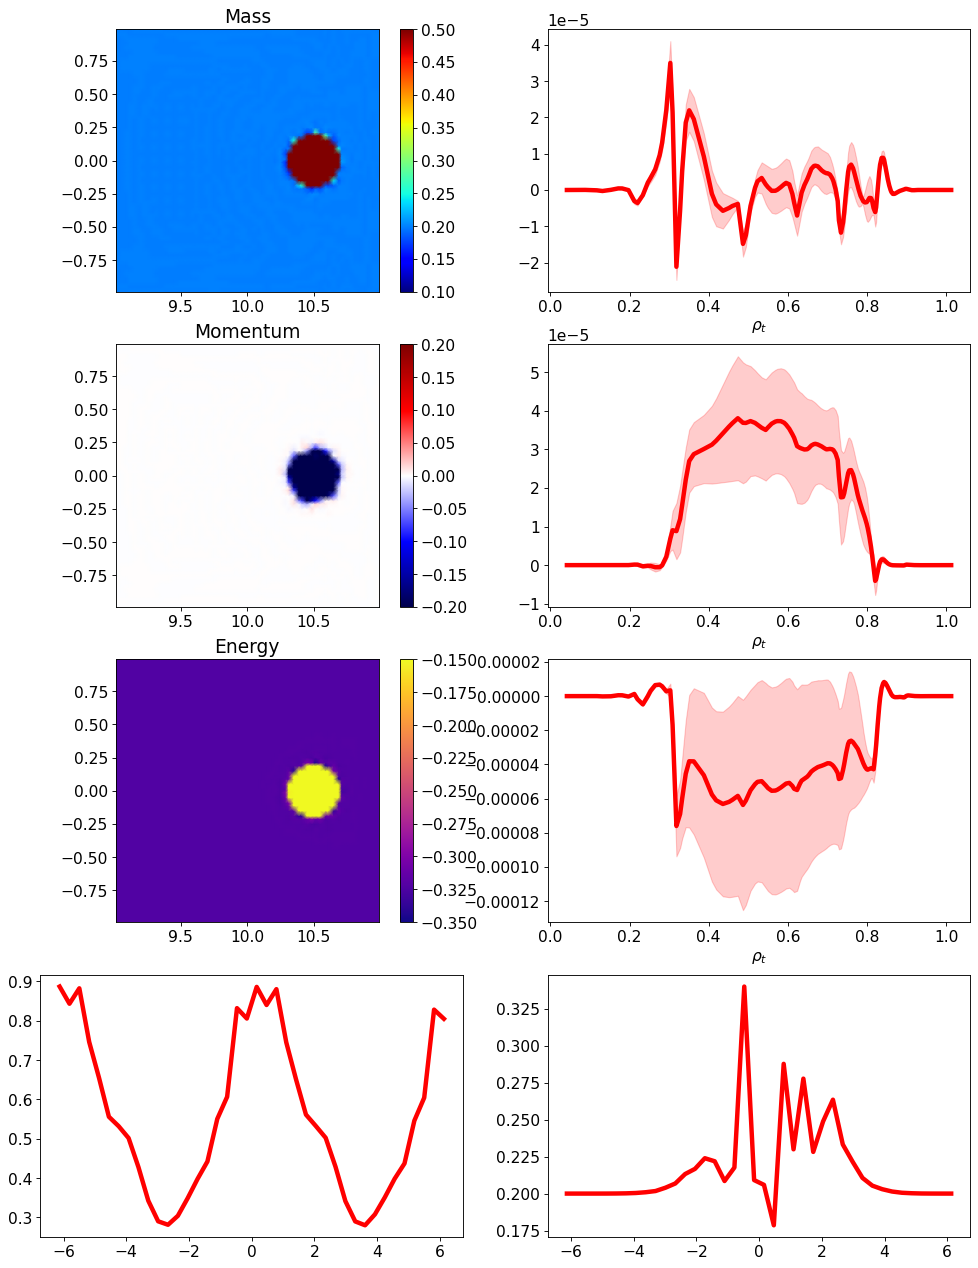

file : ThreeDimensional/data/19dc7c80fadf5dc71805d557143bfa9ed16cdce9.nc
scheme = velocity-staggered limiter = none time = 10.00
n: 3, Nx: 20, Nz: 20, mx: 5, method: linear


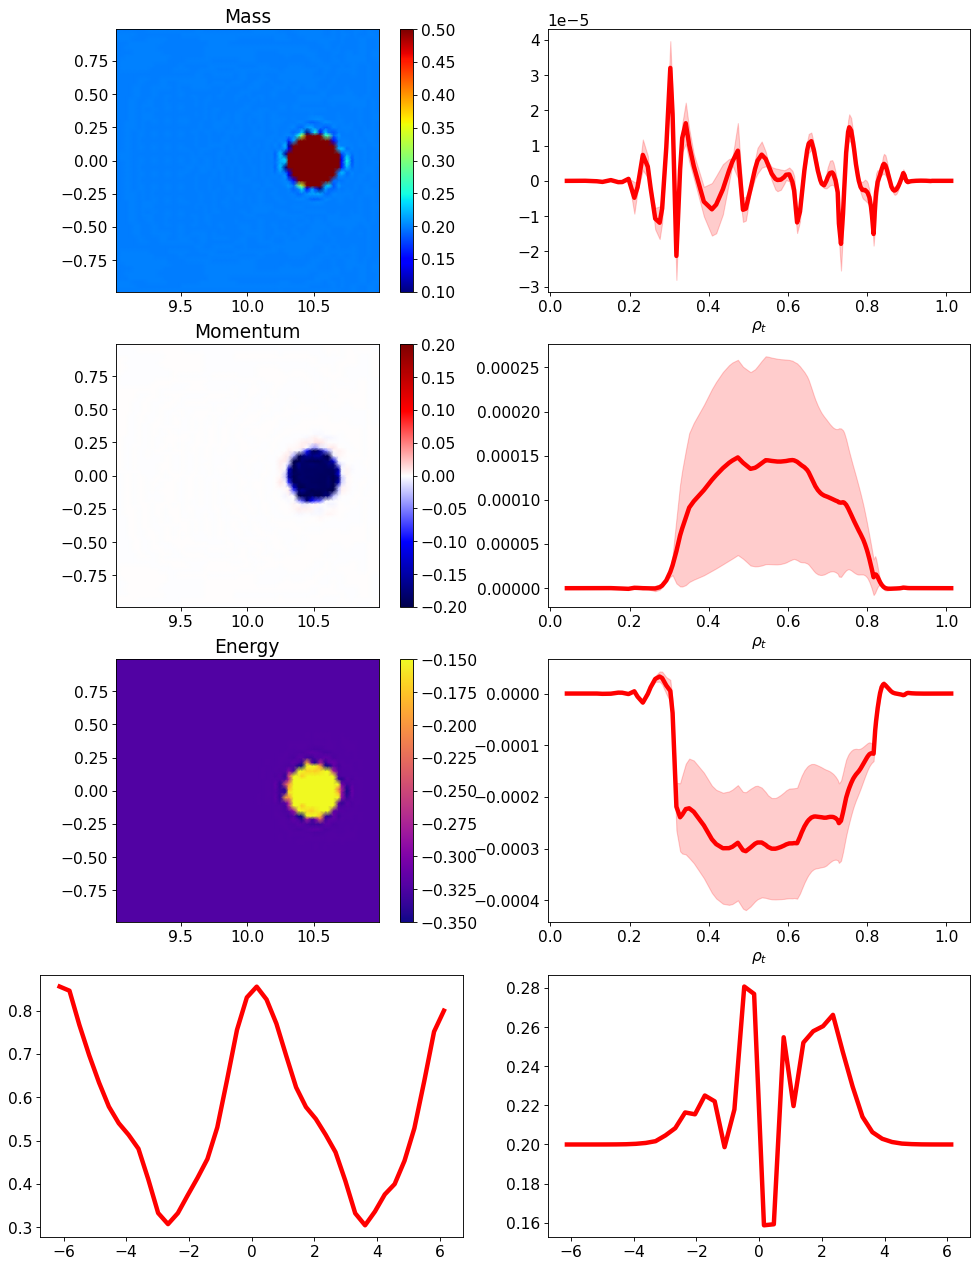

In [13]:
for scheme in ["centered",  "velocity-staggered"]: #"centered-forward",
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["advection"]["type"] = scheme
    simulationfile["physical"]["nu_parallel"] = [0,1]
    simulationfile["FCI"]["refine"] = [5,5]

    simulationfile["grid"]["Nx"] = 20
    simulationfile["grid"]["Ny"] = 20
    simulationfile["grid"]["Nz"] = 20
    if( scheme == "velocity-staggered"):
        simulationfile["FCI"]["interpolation-method"] = "linear"
        for limiter in ["none"] :# , "vanLeer", "minmod"] :
            simulationfile["advection"]["slope-limiter"] = limiter
            simfile = simulator.create( simulationfile)
            diagfile = diagnoser.create( simulationfile)
            plotfile = interpolator.create( simulationfile)
            plot_conservation(simfile, diagfile, plotfile,5)
    else:
        for method in ["linear"] : #, "dg"
            simulationfile["FCI"]["interpolation-method"] = method
            simulationfile["advection"]["slope-limiter"] = "none"
            simfile = simulator.create( simulationfile)
            diagfile = diagnoser.create( simulationfile)
            plotfile = interpolator.create( simulationfile)
            plot_conservation(simfile, diagfile, plotfile,5)
# rep = simplesim.Repeater( "./feltor.sh", "temp.json", "temp.nc")
# rep.run ( simulationfile)

Our next test reveals a problem of the current scheme. The oscillations inherent in the parallel derivative manifest strongly after a long time. We also note here that with the "dg" interpolation scheme the velocity-staggered scheme becomes unstable very quickly. After a sufficient time there is a risk that also this scheme becomes unstable.
This problem also does not vanish by increasing the resolution or the refinement of the FCI scheme.

file : ThreeDimensional/data/b8739b19269ec888010360a835eefba73f4622dd.nc
scheme = velocity-staggered limiter = minmod time = 100.00
n: 3, Nx: 32, Nz: 20, mx: 5, method: linear


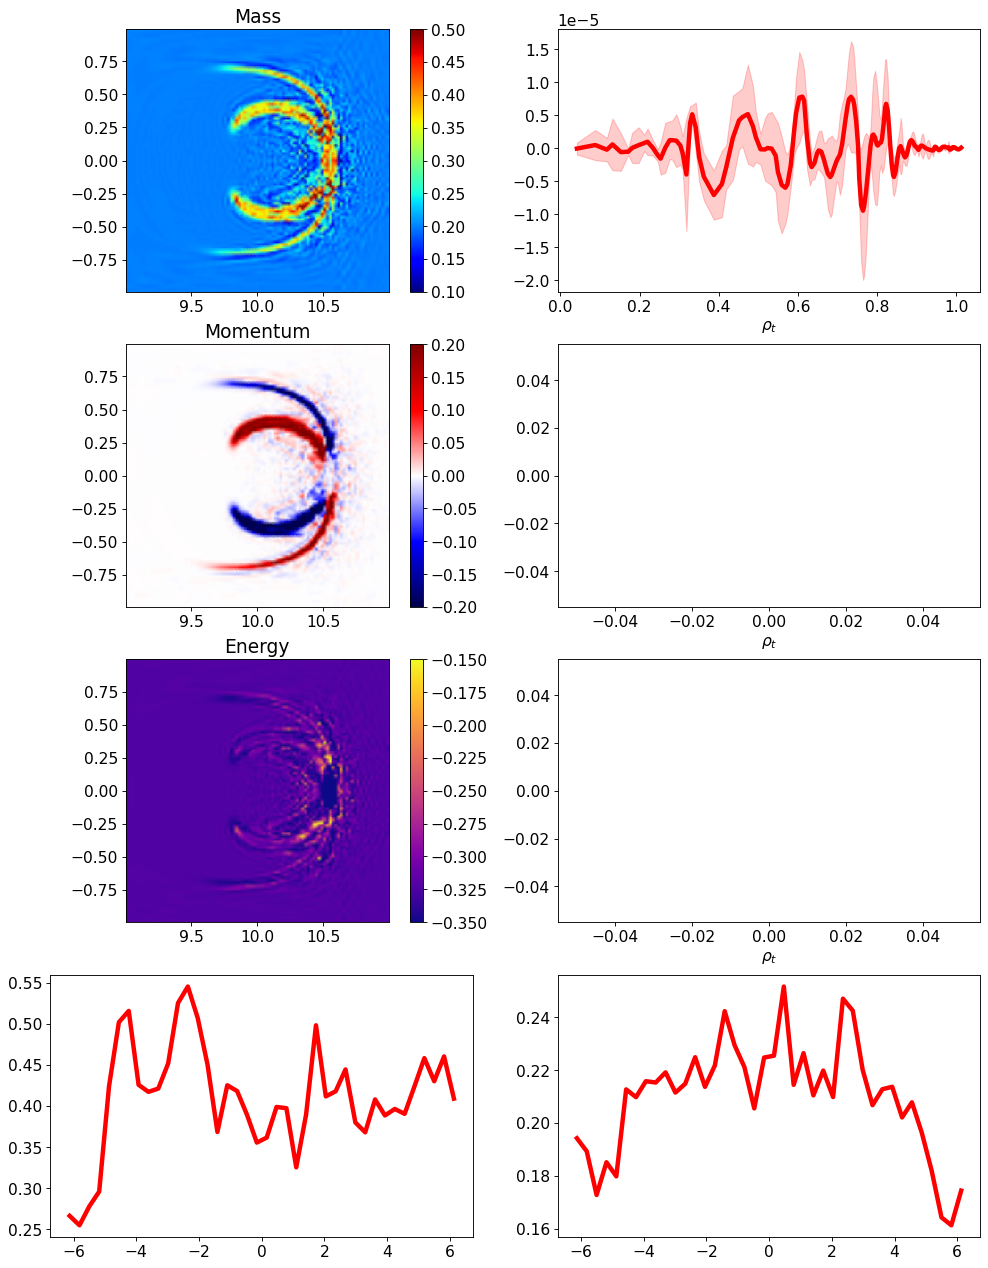

In [14]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered"
simulationfile["physical"]["nu_parallel"] = [0,0]
simulationfile["FCI"]["refine"] = [5,5]
simulationfile["FCI"]["interpolation-method"] = "linear"
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "minmod"
simulationfile["timestepper"]["Tend"] = 100
simulationfile["regularization"]["nu_perp_n"] = 0
simulationfile["regularization"]["nu_perp_u"] = 0
simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
plot_conservation(simfile, diagfile, plotfile,5)

Let us therefore add a perpendicular diffusion operator to the equations.
Our first attempt uses the "centered" direction, which however produces oscillations. These oscillations increase by increasing the order of the polynomials and decrease (but do not vanish entirely) by increasing the perpendicular resolution. 
The parallel resolution seems not to matter for that phenomenon

file : ThreeDimensional/data/8047d40e67f13995f587f5b969417a9582f9d336.nc
scheme = velocity-staggered limiter = none time = 10.00
n: 3, Nx: 32, Nz: 20, mx: 5, method: linear


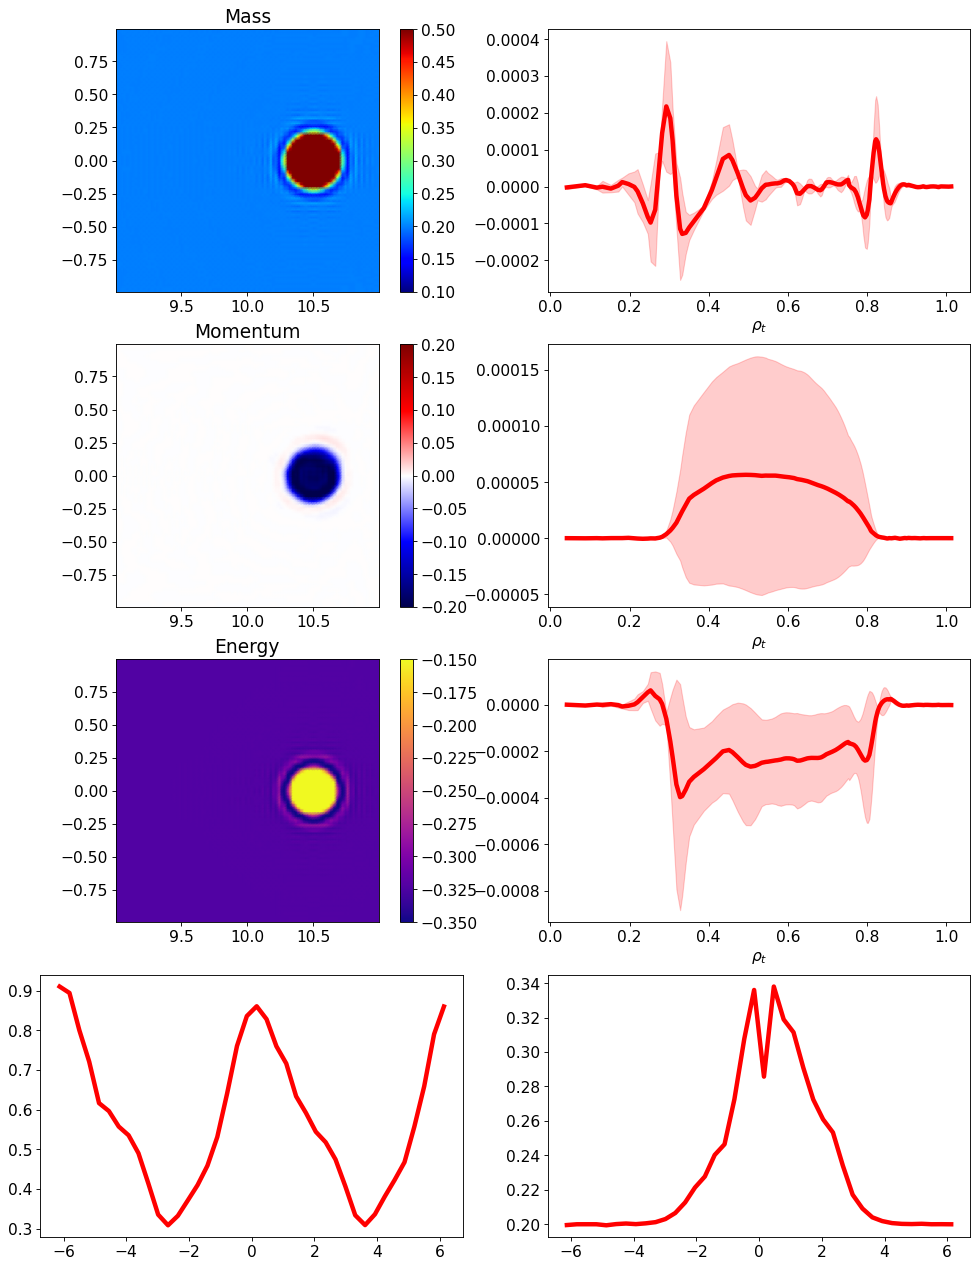

In [15]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered"
simulationfile["physical"]["nu_parallel"] = [0,1]
simulationfile["FCI"]["refine"] = [5,5]
simulationfile["FCI"]["interpolation-method"] = "linear"
simulationfile["grid"]["n"] = 3 # order 6 makes more oscis
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 10
simulationfile["regularization"]["order"] = 2
simulationfile["regularization"]["direction"] = "centered"
simulationfile["regularization"]["nu_perp_n"] = 1e-8
simulationfile["regularization"]["nu_perp_u"] = 1e-8
simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
plot_conservation(simfile, diagfile, plotfile,5)

Only if we change the direction to "forward" do the oscillations vanish:

file : ThreeDimensional/data/940f7db8ca081b8549f603de1539eccd15752159.nc
scheme = velocity-staggered limiter = none time = 10.00
n: 3, Nx: 32, Nz: 20, mx: 5, method: linear


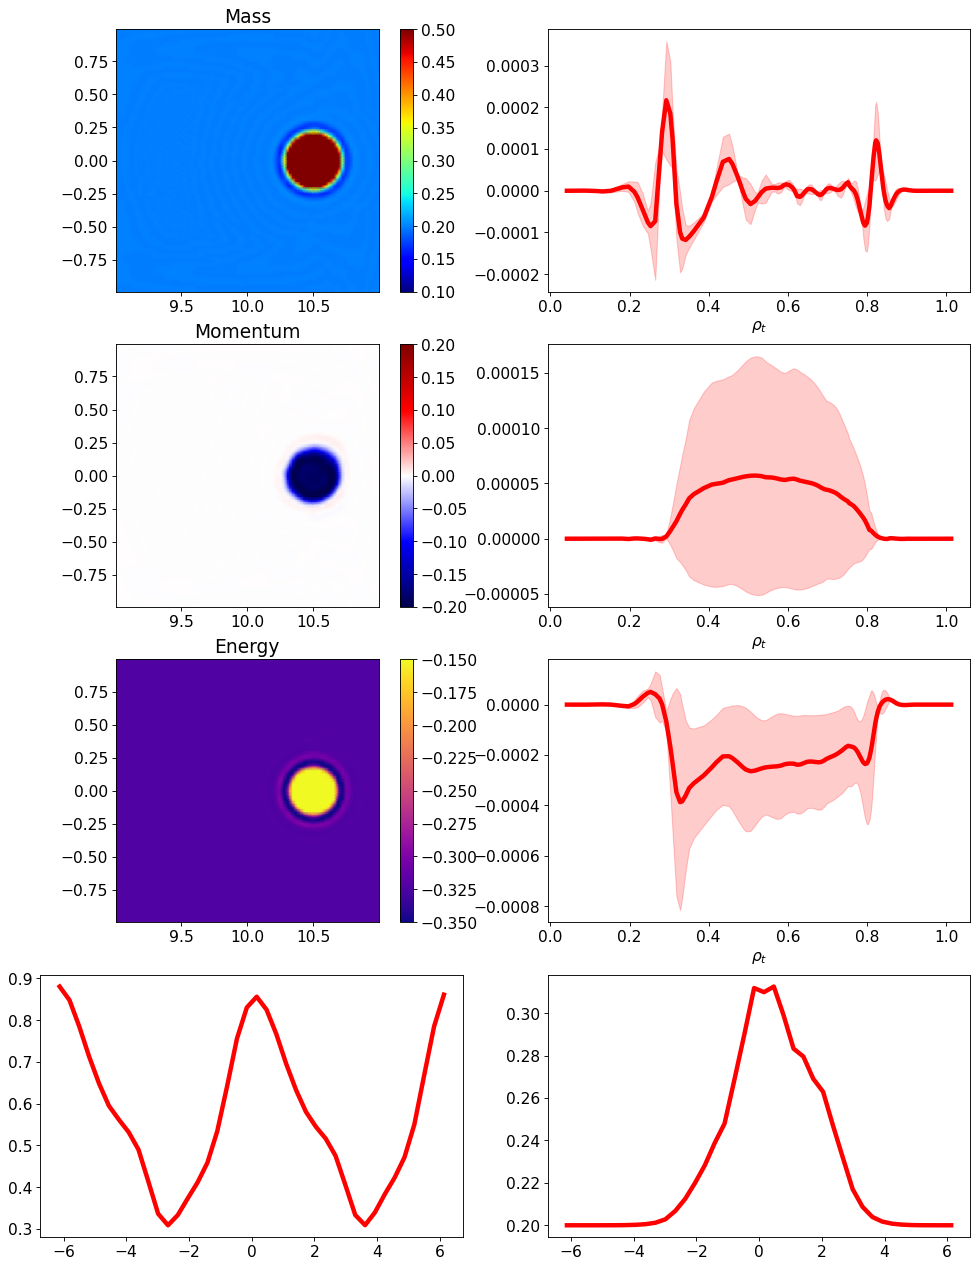

In [16]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered"
simulationfile["physical"]["nu_parallel"] = [0,1]
simulationfile["FCI"]["refine"] = [5,5]
simulationfile["FCI"]["interpolation-method"] = "linear"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 10
simulationfile["regularization"]["order"] = 2
simulationfile["regularization"]["direction"] = "forward"
simulationfile["regularization"]["nu_perp_n"] = 1e-8
simulationfile["regularization"]["nu_perp_u"] = 1e-8
simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
plot_conservation(simfile, diagfile, plotfile,5)

We are thus ready to simulate the double-step problem for a long time and high resolution:

file : ThreeDimensional/data/73f38209451ef1d910d51f0c7ef2e843f21e9711.nc
scheme = velocity-staggered limiter = none time = 80.00
n: 3, Nx: 50, Nz: 50, mx: 5, method: linear


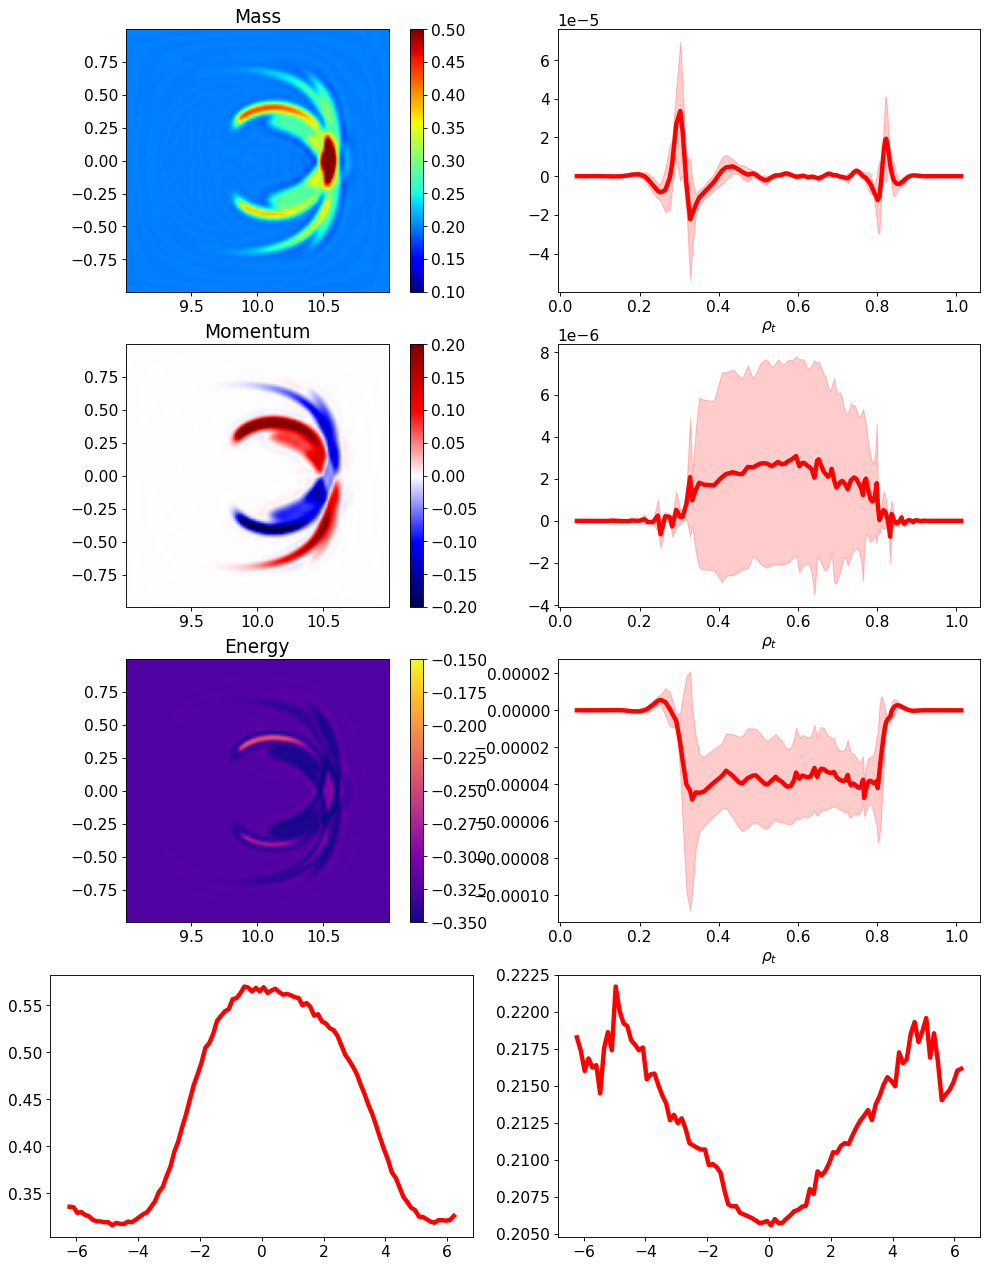

In [17]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered"
simulationfile["physical"]["nu_parallel"] = [0,1]
simulationfile["FCI"]["refine"] = [5,5]
simulationfile["FCI"]["interpolation-method"] = "linear"
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 100
simulationfile["regularization"]["order"] = 2
simulationfile["regularization"]["direction"] = "forward"
simulationfile["regularization"]["nu_perp_n"] = 1e-9
simulationfile["regularization"]["nu_perp_u"] = 1e-9
simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
plot_conservation(simfile, diagfile, plotfile,4)

On the diffusion problem:
- direct diffusion operator is unstable without support operator
- direct diffusion operator is stable with support operator